In [4]:
import sys,os,pandas,numpy

import scipy,scipy.stats

import matplotlib,matplotlib.pyplot
matplotlib.rcParams.update({'font.size':40,'font.family':'Arial','xtick.labelsize':20,'ytick.labelsize':20,'axes.labelsize':33})
matplotlib.rcParams['pdf.fonttype']=42

# 0. user defined variables

In [5]:
count_dir='/Volumes/omics4tb2/alomana/projects/TLR/data/ecoli/counts/'

In [16]:
metadata={}
metadata['SRR4023274']='fp.rep.1'
metadata['SRR4023275']='fp.rep.2'
metadata['SRR4023276']='fp.rep.3'
metadata['SRR4023277']='mrna.rep.1'
metadata['SRR4023278']='mrna.rep.2'
metadata['SRR4023279']='mrna.rep.3'

# 1. read files

In [17]:

input_file=count_dir+sample+'.txt'
df=pandas.read_csv(input_file,sep='\t',header=None,names=['transcriptID','counts'],index_col=0,skipfooter=5)
df

/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


counts
transcriptID               
transcript:AAC73112     181
transcript:AAC73113     217
transcript:AAC73114     105
transcript:AAC73115     351
transcript:AAC73116       3
...                     ...
transcript:ACO60013       0
transcript:ADO17949      51
transcript:AEN84234       0
transcript:AGW80435       0
transcript:AHA50631      24

[4140 rows x 1 columns]

In [18]:
myList=[]
for sample in metadata.keys():
    print(sample)
    input_file=count_dir+sample+'.txt'
    print(input_file)
    df=pandas.read_csv(input_file,sep='\t',header=None,names=['transcriptID','counts'],index_col=0,skipfooter=5)
    df.rename(columns={"counts": "{}".format(metadata[sample])},inplace=True)
    myList.append(df)
    print(df.head())
    print(df.tail())
    print(df.shape)
    print()

SRR4023274
/Volumes/omics4tb2/alomana/projects/TLR/data/ecoli/counts/SRR4023274.txt
                     fp.rep.1
transcriptID                 
transcript:AAC73112       181
transcript:AAC73113       217
transcript:AAC73114       105
transcript:AAC73115       351
transcript:AAC73116         3
                     fp.rep.1
transcriptID                 
transcript:ACO60013         0
transcript:ADO17949        51
transcript:AEN84234         0
transcript:AGW80435         0
transcript:AHA50631        24
(4140, 1)

SRR4023275
/Volumes/omics4tb2/alomana/projects/TLR/data/ecoli/counts/SRR4023275.txt
                     fp.rep.2
transcriptID                 
transcript:AAC73112       880
transcript:AAC73113      1838
transcript:AAC73114       357
transcript:AAC73115       919
transcript:AAC73116        16
                     fp.rep.2
transcriptID                 
transcript:ACO60013         0
transcript:ADO17949       138
transcript:AEN84234        30
transcript:AGW80435         0
transcript:

/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [19]:
df=pandas.concat(myList,axis=1)
print(df.shape)
df.head()

(4140, 6)


fp.rep.1  fp.rep.2  fp.rep.3  mrna.rep.1  mrna.rep.2  \
transcriptID                                                                
transcript:AAC73112       181       880       533         183         137   
transcript:AAC73113       217      1838      1590         544         241   
transcript:AAC73114       105       357       383         389          88   
transcript:AAC73115       351       919      1050         566         151   
transcript:AAC73116         3        16         6          43          12   

                     mrna.rep.3  
transcriptID                     
transcript:AAC73112          34  
transcript:AAC73113         173  
transcript:AAC73114          42  
transcript:AAC73115          86  
transcript:AAC73116           7

# 2. analysis

## 2.1. noise

/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


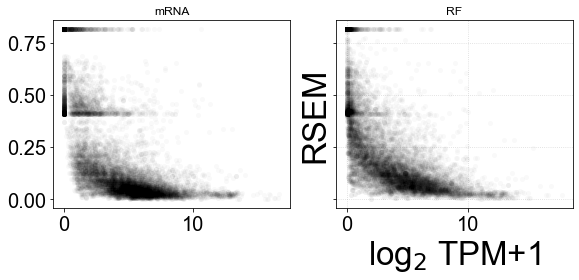

In [6]:
transcriptx=[]; transcripty=[]
footprintx=[]; footprinty=[]
gene_names=df.index.to_list()

for gene_name in gene_names:
    
    # data transformation
    log2M=numpy.log2(numpy.array(df.loc[gene_name,['mrna.rep.1','mrna.rep.2','mrna.rep.3']]+1))
    log2F=numpy.log2(numpy.array(df.loc[gene_name,['fp.rep.1','fp.rep.2','fp.rep.3']]+1))
    
    # error
    sem=numpy.std(log2M)/numpy.sqrt(len(log2M))
    rsem_mRNA=sem/numpy.mean(log2M)
    
    sem=numpy.std(log2F)/numpy.sqrt(len(log2F))
    rsem_RF=sem/numpy.mean(log2F)
    
    # appending
    transcriptx.append(log2M); transcripty.append(rsem_mRNA)
    footprintx.append(log2F); footprinty.append(rsem_RF)
    

# plot
fig, (ax1, ax2) = matplotlib.pyplot.subplots(1,2, figsize=(8,4), sharey=True)

ax1.plot(transcriptx,transcripty,'o',color='black',alpha=0.025,ms=5,mew=0,label='mRNA')
ax1.set_title('mRNA')

ax2.plot(footprintx,footprinty,'o',color='black',alpha=0.025,ms=5,mew=0,label='FP')
ax2.set_title('RF')
    
matplotlib.pyplot.xlabel('log$_{2}$ TPM+1')
matplotlib.pyplot.ylabel('RSEM')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

## 2.2. discriminating

In [7]:
rsem_threshold=1/3

In [8]:
gene_names=df.index.to_list()

setx=[]; sety=[]
hollowx=[]; hollowy=[]

for gene_name in gene_names:
    
    # data transformation
    log2M=numpy.log2(numpy.array(df.loc[gene_name,['mrna.rep.1','mrna.rep.2','mrna.rep.3']]+1))
    log10M=numpy.log10(numpy.array(df.loc[gene_name,['mrna.rep.1','mrna.rep.2','mrna.rep.3']]+1))
    log2F=numpy.log2(numpy.array(df.loc[gene_name,['fp.rep.1','fp.rep.2','fp.rep.3']]+1))
    
    # noise
    if numpy.max(log2M) > numpy.log2(10+1): # if expression is below 10 TPMs, don't consider noise
        sem=numpy.std(log2M)/numpy.sqrt(len(log2M))
        rsem_mRNA=sem/numpy.mean(log2M)
    else:
        rsem_mRNA=0

    if numpy.max(log2F) > numpy.log2(10+1): # if expression is below 10 TPMs, don't consider noise
        sem=numpy.std(log2F)/numpy.sqrt(len(log2F))
        rsem_RF=sem/numpy.mean(log2F)
    else:
        rsem_RF=0
        
    # medians and ratio
    m=numpy.median(log10M)
    r=numpy.median(log2F)-numpy.median(log2M)
    
    # exclude zero values
    if numpy.max([m,r]) > 0:
    
        # differenciate between trasncripts with or without footprints or inverse
        if numpy.median(log2F) == 0:
            if rsem_mRNA < rsem_threshold:
                hollowx.append(m); hollowy.append(r)
        elif numpy.median(log2M) == 0:
            if rsem_RF < rsem_threshold:
                hollowx.append(m); hollowy.append(r)
        else:
            if rsem_mRNA < rsem_threshold and rsem_RF < rsem_threshold:        
                setx.append(m); sety.append(r)     

## 2.3 regression model

In [9]:
# perform regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(setx,sety)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# compute for the model
m=slope
c=intercept
expected=list(m*numpy.array(setx)+c)

	 regression results:
		 slope 0.10072602440006165
		 intercept -0.7356798453758275
		 r_value 0.07587866377675115
		 pvalue 1.4314052346827311e-05
		 std_err 0.023178896984650792


# 3. plot

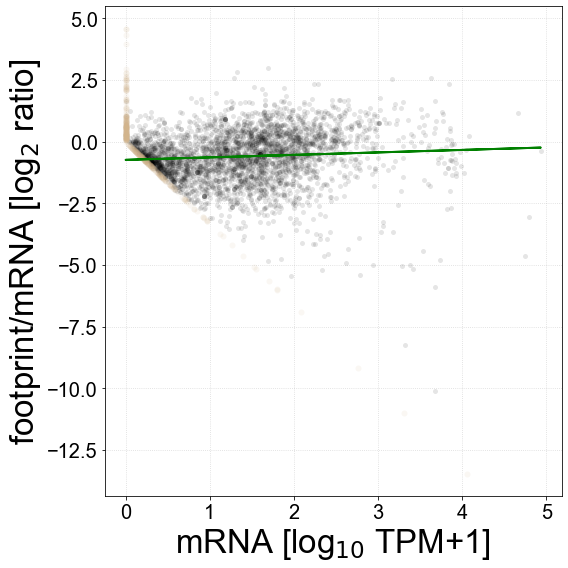

In [10]:
matplotlib.pyplot.figure(None,(8,8))

matplotlib.pyplot.plot(setx,sety,'o',color='black',alpha=0.1,ms=5,mew=0)
matplotlib.pyplot.plot(hollowx,hollowy,'o',alpha=0.1,mew=0,color='tan')

matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')
matplotlib.pyplot.plot(setx,expected,'-',lw=2,color='green')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()